In [1]:
# Load in out libraries
import pandas as pd
import numpy as np
import re # 파이썬 정규식 모듈
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
# Feature Exploration, Engineering and Cleasing
# Load in the train and test datasets
train = pd.read_csv("C:/python_directory/titanic/train.csv")
test = pd.read_csv("C:/python_directory/titanic/test.csv")

# Store out passenger ID for easy access
PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature Engineering

In [3]:
# Feature Engineering
full_data = [train,test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature the tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x : 0 if type(x) == float else 1)

In [4]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data :
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

In [5]:
# Remove all Nulls in the Embarked column
for dataset in full_data :
  dataset['Embarked'] = dataset['Embarked'].fillna("S")
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [6]:
train['Fare'].median

<bound method NDFrame._add_numeric_operations.<locals>.median of 0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64>

In [7]:
# Create a New feature categoricalAge
for dataset in full_data :
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [8]:
# Define function to extract titles from passenger names
def get_title(name) :
  title_search = re.search(' ([A-Za-z]+)\.', name) 
  # 정규식 모듈을 이용해서 title search 수행 (공백+문자+. 으로 이뤄진 분을 찾아옴)
  # If the title exists, extract and return it
  if title_search :
    return title_search.group(1) # group(0) : 공백과 점을 포함한 모든걸 가져옴 / group(1) : 문자부분만 가져옴
  return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data :
  dataset['Title'] = dataset['Name'].apply(get_title)

In [9]:
# re.search 부분 이해하기
name = 'haein, Misss. Cho'

title_search = re.search(' ([A-Za-z]+)\.', name) # 정규식 모듈을 이용해서 title search 수행(문자로 시작하는 부분 가져옴)
# If the title exists, extract and return it
print(title_search.group(1))
title_search.group(0)

Misss


' Misss.'

In [10]:
# Mapping
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[(dataset['Fare'] <= 7.91), 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31), 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[(dataset['Age'] <= 16), 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64), 'Age'] = 4

In [11]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

# data cleasing 완료

# Visualization

In [12]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

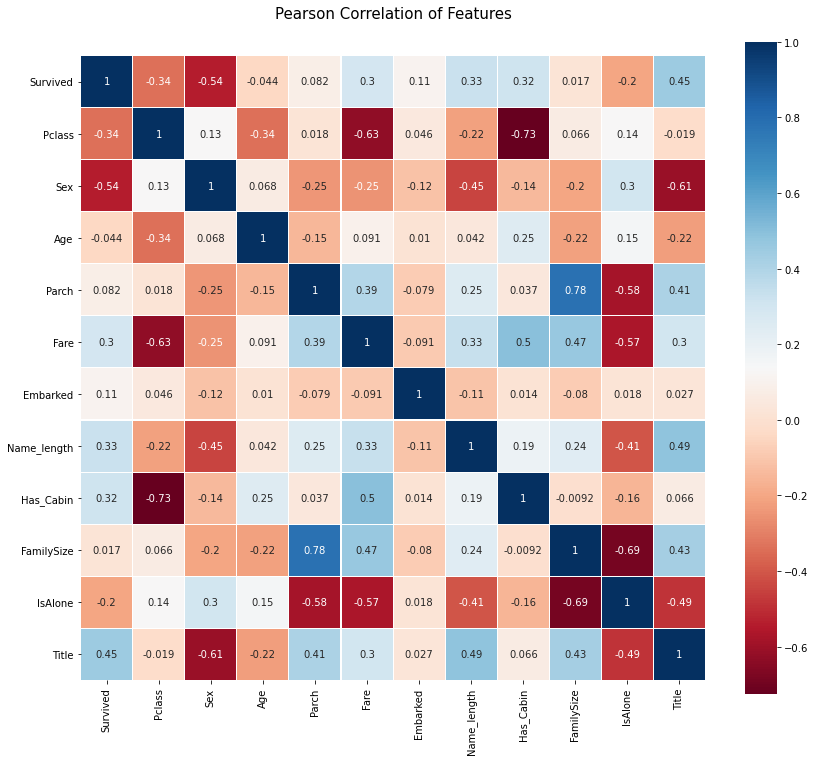

In [13]:
# Pearson Correlation Heatmap

colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=-.1, vmax=1.0, # vmax : colormap의 최대값 지정
            square=True, cmap=colormap, linecolor='white', annot=True)

# 엄청 과하게 연관되어있는 변수는 따로 없음(가장 연관되어있는 경우 : familysize, parch)
# 여기서 이 두 변수는 그대로 사용하기로 결정

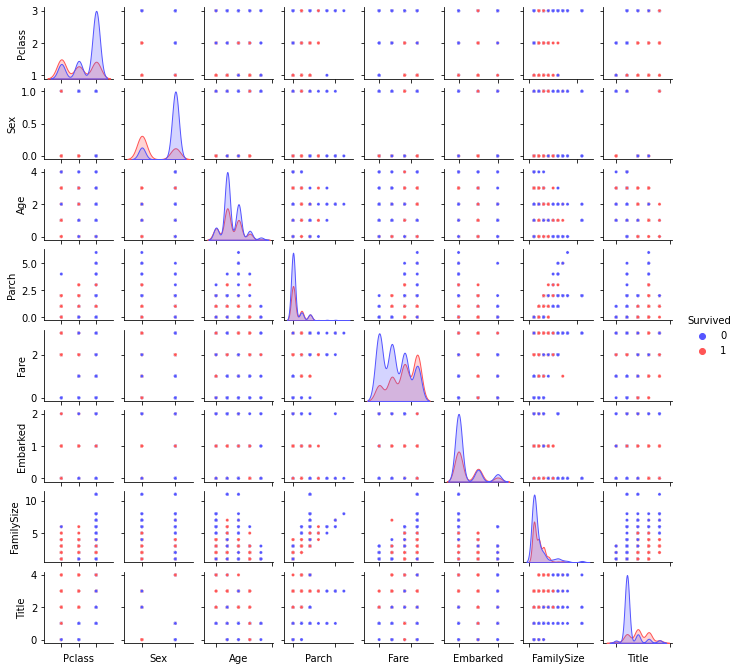

In [14]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models

In [15]:
# some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set for out-of-fold prediction
#kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED) # : 작동 X
kf = KFold(n_splits= NFOLDS, random_state=SEED, shuffle=True) # 작동하는 문장

In [16]:
# Class to extend the sklearn classifier 
#(여러작업을 한번에 결과 나오게 하기 위해서 함수 지정)
class SklearnHelper(object) :
  def __init__(self, clf, seed=0, params = None) :
    params['random_state'] = seed
    self.clf = clf(**params)

  def train(self, x_train, y_train) :
    self.clf.fit(x_train, y_train)

  def predict(self, x) :
    return self.clf.predict(x)

  def fit(self, x, y) :
    return self.clf.fit(x,y)

  def feature_importances_(self, x, y) :
    print(self.clf.fit(x,y).feature_importances_)

# Class to extend XGboost classifier


In [17]:
def get_oof(clf, x_train, y_train, x_test) :
  oof_train = np.zeros((ntrain,))
  oof_test = np.zeros((ntest,))
  oof_test_skf = np.empty((NFOLDS, ntest))

  for i, (train_index, test_index) in enumerate(kf.split(train)) :
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[test_index]

    clf.train(x_tr, y_tr)

    oof_train[test_index] = clf.predict(x_te)
    oof_test_skf[i, :] = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0)
  return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

  # enumerate : 몇번째 반복인지에 관해 index output이 같이 출력됨

# Generating our Base First-Level Models
랜포, extra trees classifier, adaboost, gradient boosting classifier, support vector machine

Parameters

n_jobs : Number of cores used for the training process. If set to -1, all cores are used.

n_estimators : Number of classification trees in your learning model ( set to 10 per default)

max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

In [18]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    # 'max_features' : 0.2,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose' : 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    # 'max_features' : 0.5,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# AdaBoost parameters
ada_params = { 
    'n_estimators' : 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators' : 500,
    # 'max_features' : 0.2,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' :0.025
}

In [19]:
# Crate 5 objects that represent out 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [20]:
# Creating Numpy arrays of train, test and target(Survived) dataframes to feed into our models
y_train = train['Survived'].ravel() # Survived 값을 array로 생성
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test data


In [21]:
x_train

array([[3., 1., 1., ..., 2., 0., 1.],
       [1., 0., 2., ..., 2., 0., 3.],
       [3., 0., 1., ..., 1., 1., 2.],
       ...,
       [3., 0., 1., ..., 4., 0., 2.],
       [1., 1., 1., ..., 1., 1., 1.],
       [3., 1., 1., ..., 1., 1., 1.]])

In [22]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # random forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # gradient boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # support vector classifier

print('Training is complete')


Training is complete


In [23]:
# Feature importances generated from the different classifiers
# 이렇게 넣으면 출력만되고 그 값이 저장되지는 않음
rf_feature = rf.feature_importances_(x_train, y_train)
et_featue = et.feature_importances_(x_train, y_train)
ada_feature = ada.feature_importances_(x_train, y_train)
gb_feature = gb.feature_importances_(x_train, y_train)

[0.10991871 0.21893356 0.02928583 0.02139902 0.04560436 0.02760572
 0.12986057 0.05034652 0.07135443 0.01024784 0.28544344]
[0.12911678 0.37404945 0.02376673 0.01578418 0.05471661 0.027836
 0.0468247  0.08197487 0.04525248 0.01851022 0.18216797]
[0.032 0.034 0.018 0.066 0.042 0.01  0.69  0.004 0.052 0.    0.052]
[0.13889086 0.02696216 0.0438486  0.01085529 0.05144218 0.02717126
 0.17570544 0.04342781 0.0823291  0.00488673 0.39448056]


In [24]:
# copy&paste로 위의 값 저장해주기
rf_feature = [0.13535969, 0.19767098, 0.02622913, 0.0211458,  0.06965937, 0.02441415,
 0.10488231, 0.06602936, 0.06930927, 0.01272839, 0.27257154]
et_featue = [0.127804,   0.3764411,  0.02548205, 0.01631131, 0.05439312, 0.02769022,
 0.04626499, 0.08090492, 0.04454332, 0.01895866, 0.18120629]
ada_feature = [0.032, 0.034, 0.02,  0.064, 0.042, 0.012, 0.684, 0.004, 0.052, 0.004, 0.052]
gb_feature = [0.13880714, 0.02713583, 0.04495665, 0.01130946, 0.0528466,  0.02574478,
 0.17612732, 0.04618982, 0.0830547,  0.00501656, 0.38881114]

In [25]:
cols = train.columns.values
# Create  a dataframe with features
feature_dataframe = pd.DataFrame({"features" : cols, 'Random Forest feature importances' : rf_feature,
                                  'Extra Trees feature importances' : rf_feature,
                                  'AdaBoost feature importances' : ada_feature,
                                  'Gradient Boost feature importances' : gb_feature})

In [26]:
# Interactive feature importances via plotly scatterplots
# plotly를 이용해서 그려지는 거라 여기서는 안나오는 것인듯??
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        #       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    #     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter2010')

In [27]:
# Scatter plot - Extra Trees
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [28]:
# Scatter plot - AdaBoost
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [29]:
# Scatter plot - Gradient Boost
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [30]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis=1) # row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.135360,0.135360,0.032,0.138807,0.110382
1,Sex,0.197671,0.197671,0.034,0.027136,0.114119
2,Age,0.026229,0.026229,0.020,0.044957,0.029354


In [33]:
# Plotly Barplot of Average Feature Importances

y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
                x=x, y=y, width = 0.5,
                marker=dict(color = feature_dataframe['mean'].values,
                           colorscale='Portland', showscale=True,
                           reversescale=False),
                opacity=0.6)]

layout = go.Layout(
                    autosize=True,
                    title = 'Barplot of Mean Feature Importance',
                    hovermode = 'closest',
                    yaxis=dict(title='Feature Importance', ticklen=5,
                              gridwidth=2),
                    showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the Firse-Level Output
### first-level output as new features
Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefor having as our new columns the first-level predictions from our earilier classifiers and we train the next classifier on this.

In [34]:
# 위에서 만든 모델들로 얻은 training에 대한 예측값
base_predictions_train = pd.DataFrame({'FandomForest' : rf_oof_train.ravel(), 'ExtraTrees':et_oof_train.ravel(), 'AdaBoost':ada_oof_train.ravel(), 'GradientBoost':gb_oof_train.ravel()})

base_predictions_train.head()

,FandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [39]:
# correlation Heatmap of the Scond Level Training set
data = [
    go.Heatmap(
    z = base_predictions_train.astype(float).corr().values,
    x = base_predictions_train.columns.values,
    y = base_predictions_train.columns.values,
    colorscale = 'Viridis',
    showscale = True,
    reversescale = True)
]
py.iplot(data,filename = 'labelled-heatmap')

# 추가로 ) 캐클 대회에서 우승한 사람들 중에 more uncorrelated 된 trained models를 사용해 더 나은 score를 얻은 경우가 있다고 함 -> 이를 이용해보자

In [44]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

# having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model

In [45]:
# Secon level learning model via XGBoost
# XGBoost is built to optimize large-sclae boosted tree algorithms
# Using XGBoost Classifier를 이용해보자

gbm = xgb.XGBClassifier(
            # learning_rate=0.02,
            n_estimators = 2000,
            max_depth = 4, min_child_weight=2,
            gamma = 0.9, subsample=0.8, colsample_bytree = 0.8,
            objective = 'binary:logistic',
            nthread = -1,
            scale_pos_weight=1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

# max_depth : How deep you want to grow your tree (값이 너무 크면 overfitting가능성 ㅇ)
# gamma : minimum loss reduction required to make a further partition on a leaf node of the tree. (클수록 보수적인(conservative) algorithm이됨 )
# eta : stepsize shrinkage used in each boosting step to prevent overfitting

[17:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
# Generate the Submiision file
stackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived' : predictions})

stackingSubmission.to_csv("stackingSubmission.csv", index=False)